In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from utils import *

pd.set_option('display.max_columns', None)

# Carga de data

In [3]:
DATA_PATH = "../data/2024_Property_Tax_Roll.csv"
df_ = pd.read_csv(DATA_PATH)

coords = df_["Property_Location"].str.extract(r"POINT\s*\(\s*([-\d\.]+)\s+([-\d\.]+)\s*\)")
df_.loc[:,"lon"] = pd.to_numeric(coords[0], errors="coerce")
df_.loc[:,"lat"] = pd.to_numeric(coords[1], errors="coerce")

## Validación de la data

In [4]:
df_.shape

(44034, 32)

In [5]:
df_.head()

,P_ID,TAX_MAP,plat,lot,unit,CLASS,SHORT_DESC,LEVY_CODE_1,SHORT_DESC 1,CIVIC,STREET,SUFFIX,FORMATED_ADDRESS,CITY,ZIP_POSTAL,FIRST_NAME,LAST_NAME,COMPANY,FREE_LINE_2,CIVIC 1,STREET 1,S_SUFFIX,UNIT,CITY 1,STATE,ZIP_POSTAL 1,TOTAL_ASSMT,TOTAL_EXEMPT,TOTAL_TAXES,Property_Location,lon,lat
0,12.0,000-0001-0022,0.0,1.0,0022,10.0,Utility,C01,C01,NaN,NaN,NaN,NaN,Providence,NaN,NaN,NaN,Algonquin Gas Transmission LLC,PO BOX 2629,NaN,NaN,NaN,NaN,Addison,TX,75001,6160000.0,0.0,216216.00,POINT (-71.412747 41.824461),-71.412747,41.824461
1,807.0,005-0514-0000,5.0,514.0,0000,1.0,Single Family,OO01,OO01,135.0,Abbott,St,135 Abbott St,Providence,02906,LYNETTE,LOPES,NaN,135 ABBOTT ST,135,ABBOTT,ST,NaN,PROVIDENCE,RI,02906-1818,436900.0,47708.0,4070.76,POINT (-71.402954036 41.842866001),-71.402954,41.842866
2,69878.0,077-0893-0000,77.0,893.0,0000,1.0,Single Family,OO01,OO01,36.0,Wilna,St,36 Wilna St,Providence,02904,K,Karpeh,NaN,36 Wilna St,36,Wilna,St,NaN,Providence,RI,02904,322600.0,0.0,3374.24,POINT (-71.415484981 41.858035988),-71.415485,41.858036
3,2050.0,008-0350-0000,8.0,350.0,0000,1.0,Single Family,OO01,OO01,120.0,Morris,Ave,120 Morris Ave,Providence,02906,NaN,NaN,NaN,120 Morris Ave,120,Morris,Ave,NaN,PROVIDENCE,RI,02906-3040,572100.0,57364.0,5383.88,POINT (-71.398264026 41.83631701),-71.398264,41.836317
4,5030.0,016-0560-0000,16.0,560.0,0000,1.0,Single Family,OO01,OO01,22.0,John,St,22 John St,Providence,02906,Fergal,Casey,NaN,22 John St,22,John,St,NaN,Providence,RI,02906,643000.0,0.0,6725.48,POINT (-71.400355981 41.821832998),-71.400356,41.821833


In [6]:

df_.dtypes

P_ID                 float64
TAX_MAP               object
plat                 float64
lot                  float64
unit                  object
CLASS                float64
SHORT_DESC            object
LEVY_CODE_1           object
SHORT_DESC 1          object
CIVIC                float64
STREET                object
SUFFIX                object
FORMATED_ADDRESS      object
CITY                  object
ZIP_POSTAL            object
FIRST_NAME            object
LAST_NAME             object
COMPANY               object
FREE_LINE_2           object
CIVIC 1               object
STREET 1              object
S_SUFFIX              object
UNIT                  object
CITY 1                object
STATE                 object
ZIP_POSTAL 1          object
TOTAL_ASSMT          float64
TOTAL_EXEMPT         float64
TOTAL_TAXES          float64
Property_Location     object
lon                  float64
lat                  float64
dtype: object

In [7]:
# Cantidad de nulos por columnas

df_.isnull().sum().sort_values(ascending=False)

UNIT                 39476
COMPANY              34902
FIRST_NAME            9738
LAST_NAME             9674
S_SUFFIX              3523
CIVIC 1               1596
SUFFIX                1592
ZIP_POSTAL            1436
STREET 1              1058
CIVIC                   96
ZIP_POSTAL 1            38
CITY                    35
STATE                   14
CITY 1                   7
FORMATED_ADDRESS         3
STREET                   3
FREE_LINE_2              3
SHORT_DESC 1             1
plat                     1
lot                      1
unit                     1
CLASS                    1
SHORT_DESC               1
LEVY_CODE_1              1
P_ID                     1
TAX_MAP                  1
TOTAL_ASSMT              1
TOTAL_EXEMPT             1
TOTAL_TAXES              1
Property_Location        0
lon                      0
lat                      0
dtype: int64

In [8]:
# Duplicidad de valores en dataframe
repetidos_por_col = {
    col: df_[col].dropna().duplicated().sum()
    for col in df_.columns
}

df_repetidos_1fila = pd.DataFrame([repetidos_por_col])
df_repetidos_1fila


,P_ID,TAX_MAP,plat,lot,unit,CLASS,SHORT_DESC,LEVY_CODE_1,SHORT_DESC 1,CIVIC,STREET,SUFFIX,FORMATED_ADDRESS,CITY,ZIP_POSTAL,FIRST_NAME,LAST_NAME,COMPANY,FREE_LINE_2,CIVIC 1,STREET 1,S_SUFFIX,UNIT,CITY 1,STATE,ZIP_POSTAL 1,TOTAL_ASSMT,TOTAL_EXEMPT,TOTAL_TAXES,Property_Location,lon,lat
0,0,0,43903,42842,42567,44006,44006,44025,44025,42489,42334,42426,2283,43993,42513,25465,18339,5482,11197,40360,37748,40463,3470,43127,43973,38740,33727,41230,25518,4434,11933,12568


In [9]:
df_.duplicated(subset=["P_ID"]).sum(), df_.duplicated(subset=["TAX_MAP"]).sum()


(np.int64(0), np.int64(0))

# EDA

In [10]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44034 entries, 0 to 44033
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   P_ID               44033 non-null  float64
 1   TAX_MAP            44033 non-null  object 
 2   plat               44033 non-null  float64
 3   lot                44033 non-null  float64
 4   unit               44033 non-null  object 
 5   CLASS              44033 non-null  float64
 6   SHORT_DESC         44033 non-null  object 
 7   LEVY_CODE_1        44033 non-null  object 
 8   SHORT_DESC 1       44033 non-null  object 
 9   CIVIC              43938 non-null  float64
 10  STREET             44031 non-null  object 
 11  SUFFIX             42442 non-null  object 
 12  FORMATED_ADDRESS   44031 non-null  object 
 13  CITY               43999 non-null  object 
 14  ZIP_POSTAL         42598 non-null  object 
 15  FIRST_NAME         34296 non-null  object 
 16  LAST_NAME          343

In [11]:
num_cols = ['plat', 'lot', 'CIVIC', 'TOTAL_ASSMT', 'TOTAL_EXEMPT', 'TOTAL_TAXES', "CLASS", "lat", "lon"]
#cat_cols_descarte = ["CLASS", "STREET", "FREE_LINE_2", "STREET 1", "S_SUFFIX", "CITY 1", "STATE", "ZIP_POSTAL 1", "COMPANY"]
cat_cols = [col for col in df_.columns if col not in num_cols] + ["CLASS"] # + cat_cols_descarte]

df_num = df_[num_cols]
df_cat = df_[cat_cols]

df_num.shape, df_cat.shape

((44034, 9), (44034, 24))

# Gráficas

## Columnas numéricas

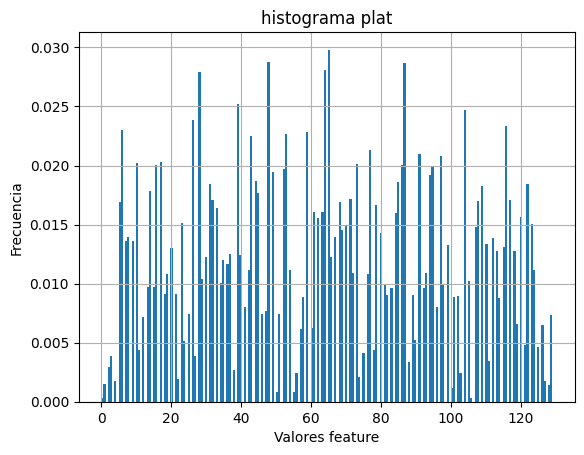

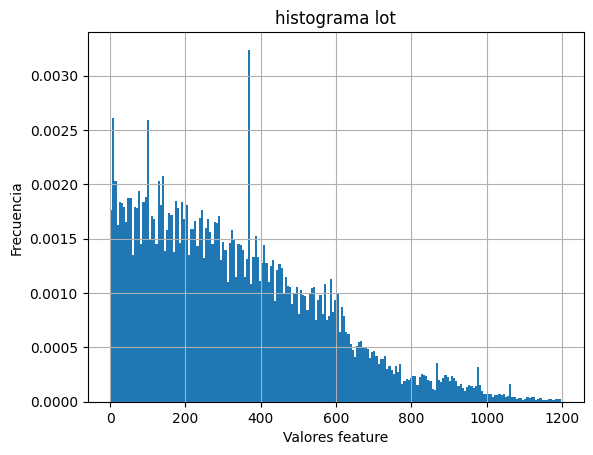

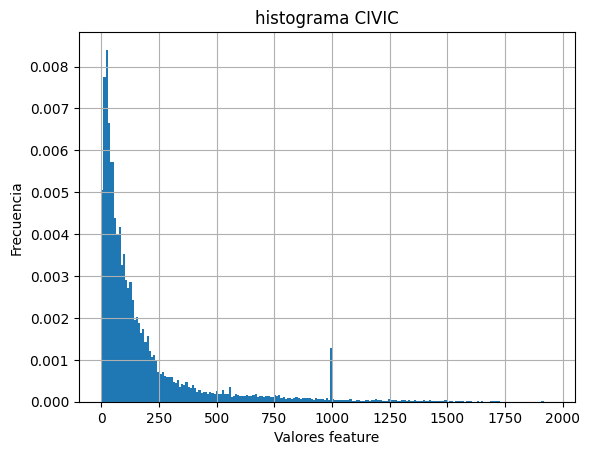

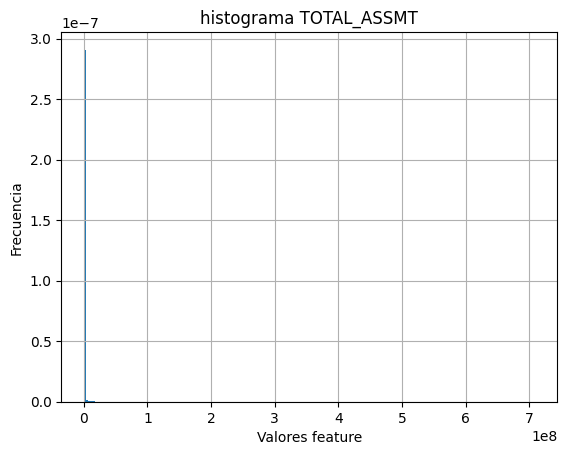

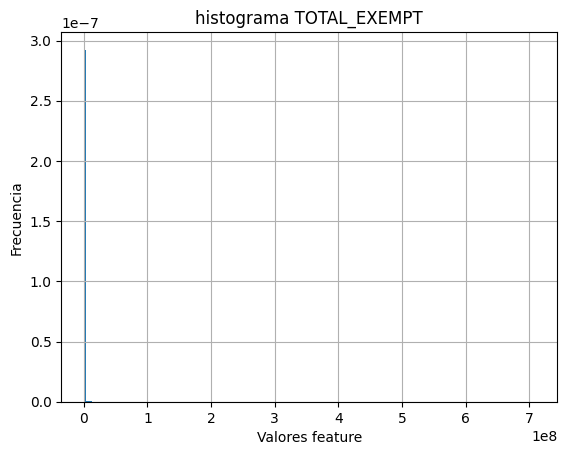

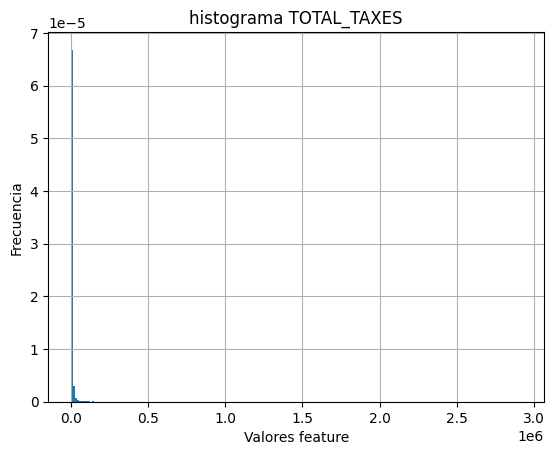

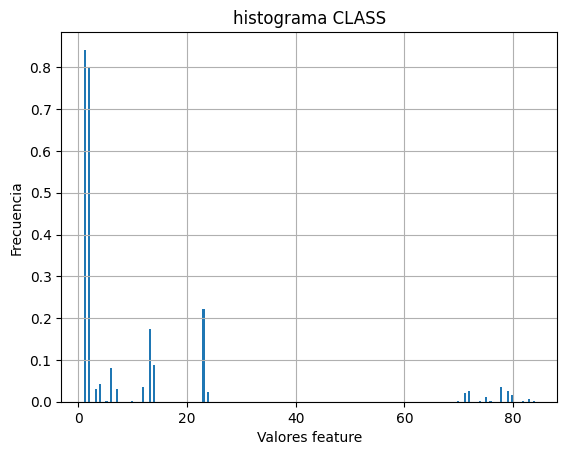

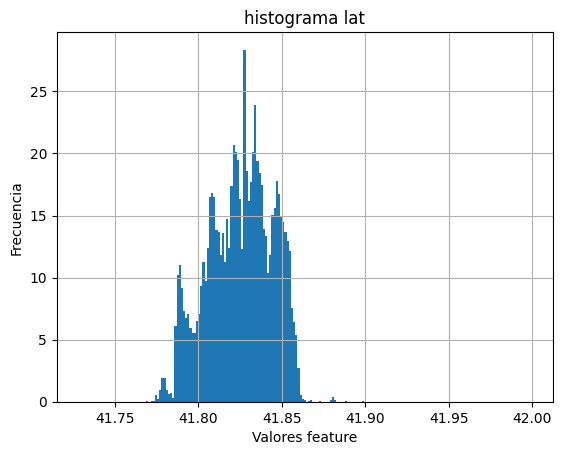

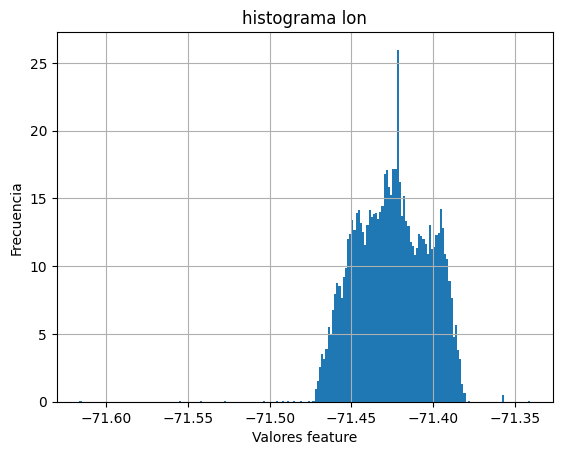

In [12]:
for col in df_num.columns:
    _, _, _ = plt.hist(df_num[col], bins=int(np.sqrt(df_num.shape[0])), density=True)
        
    plt.title(f"histograma {col}")
    plt.xlabel("Valores feature")
    plt.ylabel("Frecuencia")
    plt.grid()
    plt.show()

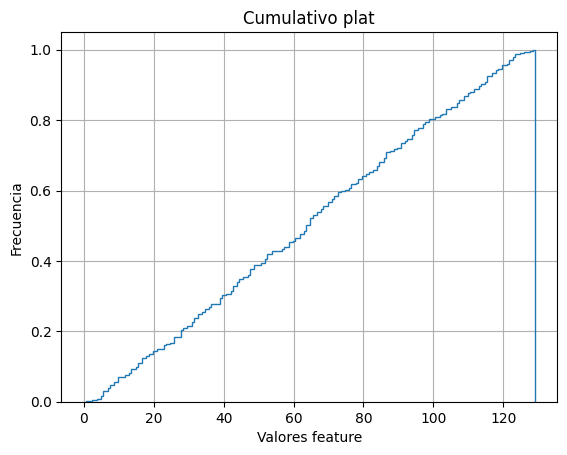

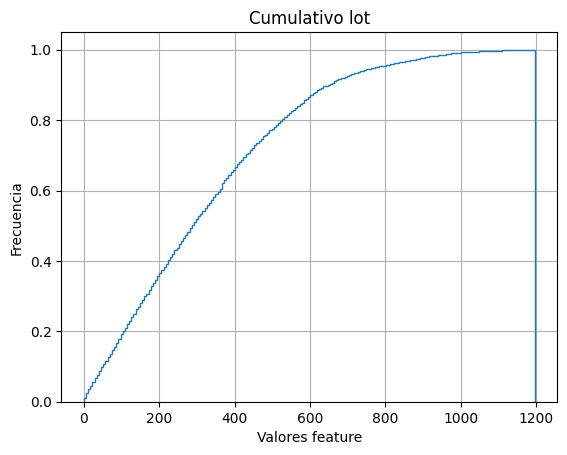

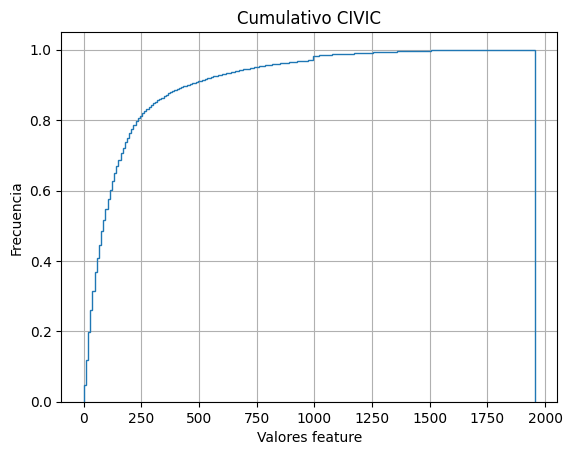

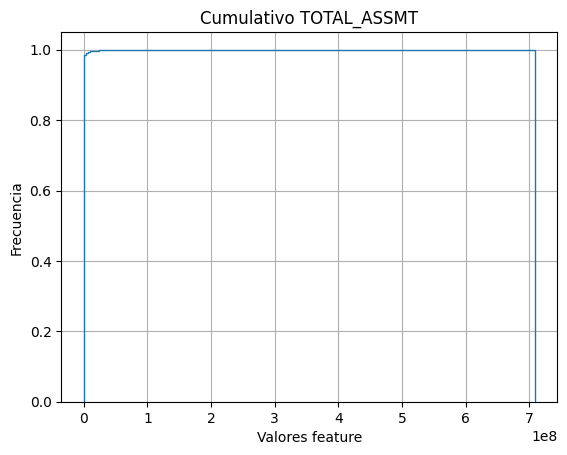

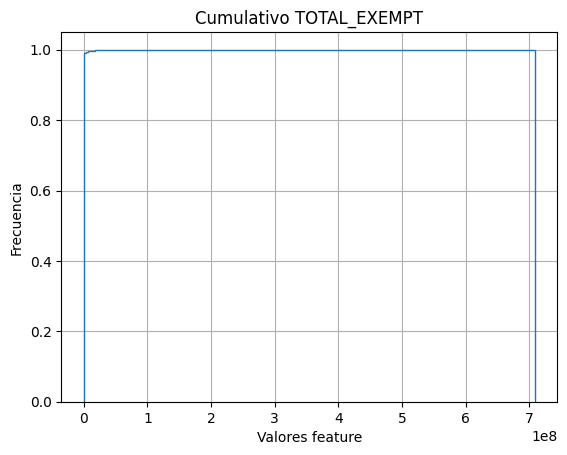

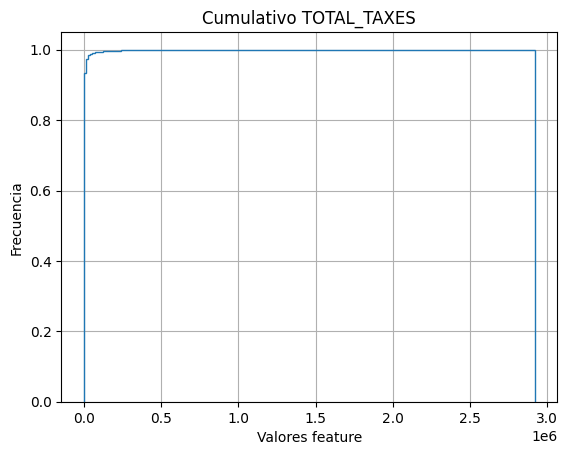

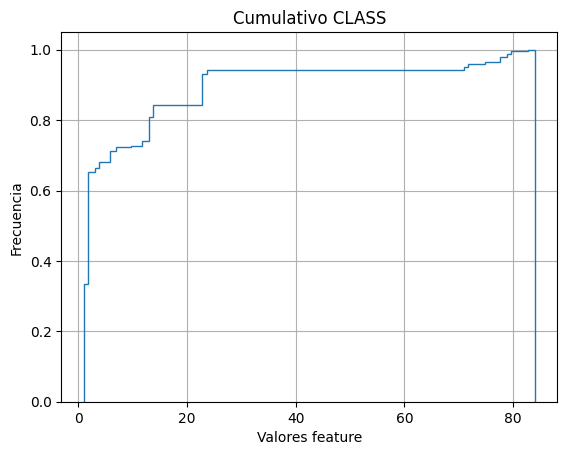

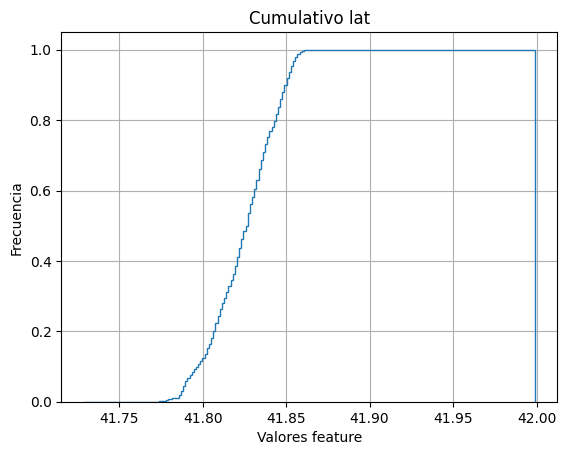

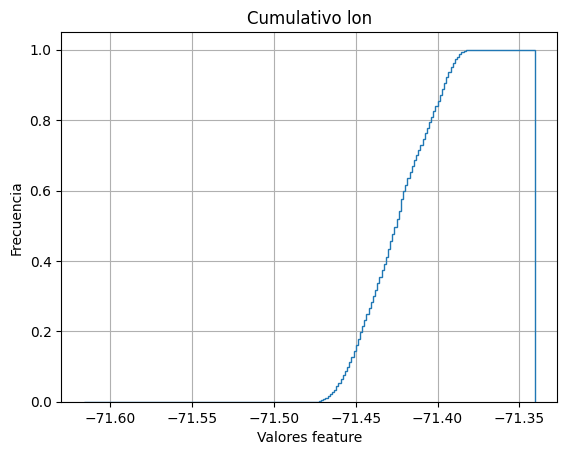

In [13]:
for col in df_num.columns:
    _, _, _ = plt.hist(df_num[col], bins=int(np.sqrt(df_num.shape[0])), density=True, cumulative=True, histtype='step')
    plt.title(f"Cumulativo {col}")
    plt.xlabel("Valores feature")
    plt.ylabel("Frecuencia")
    plt.grid()
    plt.show()

#

In [14]:
vc = df_num["CLASS"].value_counts(dropna=False)
res_class = pd.DataFrame({
    "count": vc,
    "porcentual": (vc / len(df_num) * 100).round(2)
})
res_class


,count,porcentual
CLASS,,
1.0,14725,33.44
2.0,13989,31.77
23.0,3864,8.78
13.0,3047,6.92
14.0,1536,3.49
6.0,1423,3.23
4.0,723,1.64
12.0,621,1.41
78.0,610,1.39


In [15]:
null_pct = (df_num.isnull().mean()*100).sort_values(ascending=False)
null_pct

CIVIC           0.218013
plat            0.002271
lot             0.002271
TOTAL_ASSMT     0.002271
TOTAL_EXEMPT    0.002271
TOTAL_TAXES     0.002271
CLASS           0.002271
lat             0.000000
lon             0.000000
dtype: float64

## Correlaciones de features
- La matriz de correlaciones y el VIF me ayudan a determinar si puedo realizar o no reducción de dimensionalidad dada la dependencia que exista entre features.

Text(0.5, 1.0, 'Matriz de Correlación')

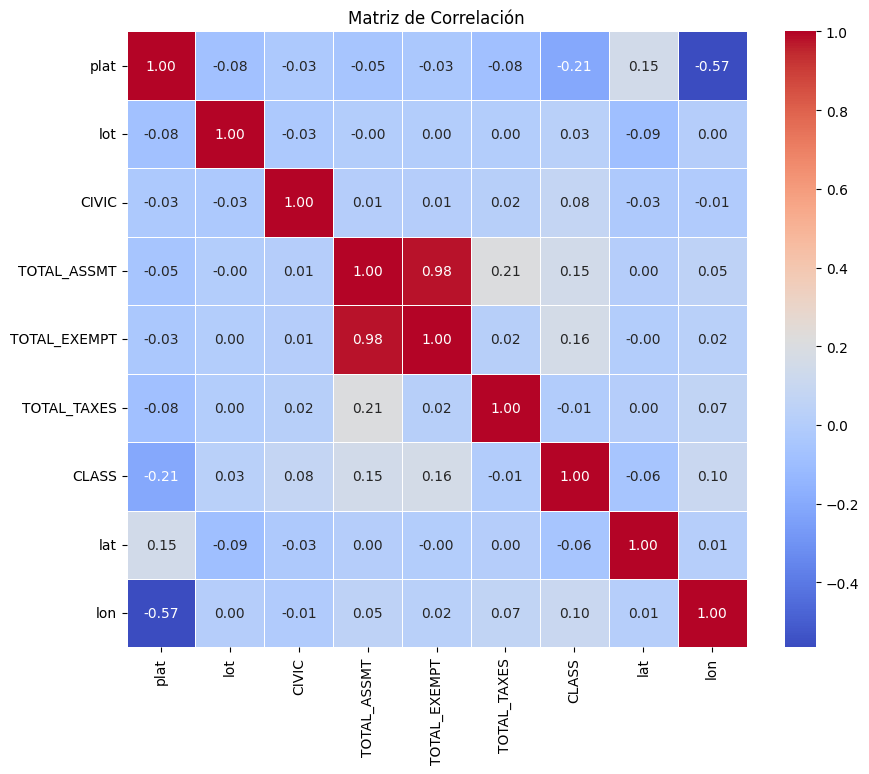

In [16]:
cor_mat = df_num.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5 )
plt.title('Matriz de Correlación')

## VIF 

In [17]:
df_num.dropna().shape, df_num.shape

((43938, 9), (44034, 9))

In [18]:
df_drop_num = df_num.dropna()
X = df_drop_num.drop(columns=['CLASS','TOTAL_EXEMPT'])  
y = df_drop_num["CLASS"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]
vif.sort_values(by="VIF",ascending=False)

,Feature,VIF
0,plat,1.540440
6,lon,1.495307
4,TOTAL_TAXES,1.053774
3,TOTAL_ASSMT,1.048950
5,lat,1.042586
1,lot,1.015602
2,CIVIC,1.003575


## Boxplot
- Los boxplot me permiten determinar si hay features con valores que puedan desbalancear el modelo

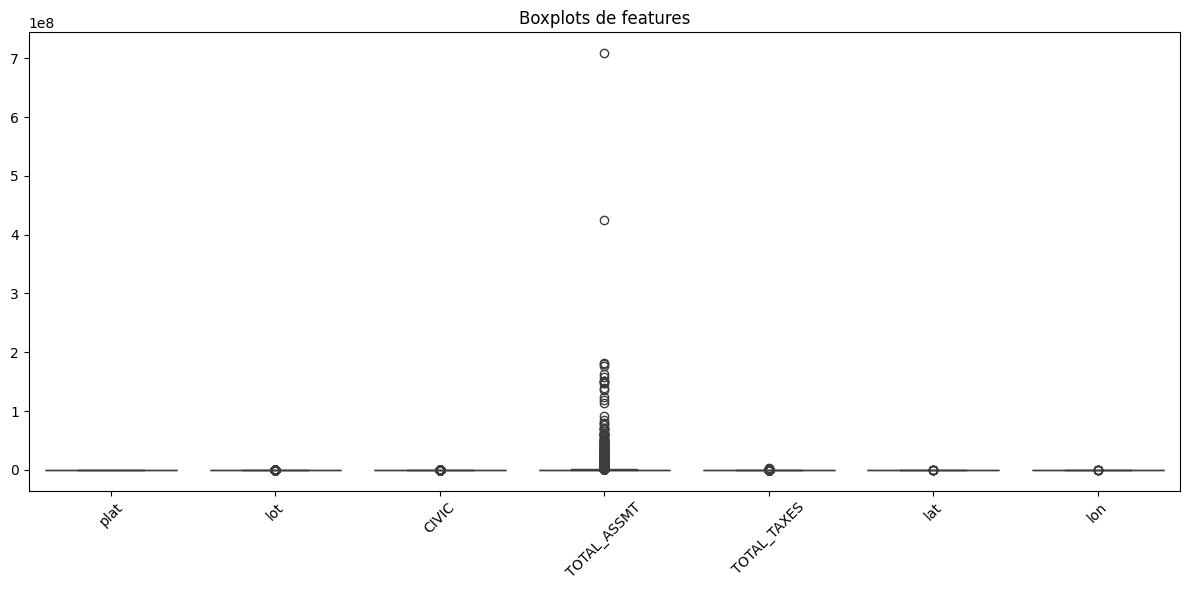

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_num.drop(columns=['CLASS','TOTAL_EXEMPT']))
plt.xticks(rotation=45)
plt.title("Boxplots de features")
plt.tight_layout()
plt.show()

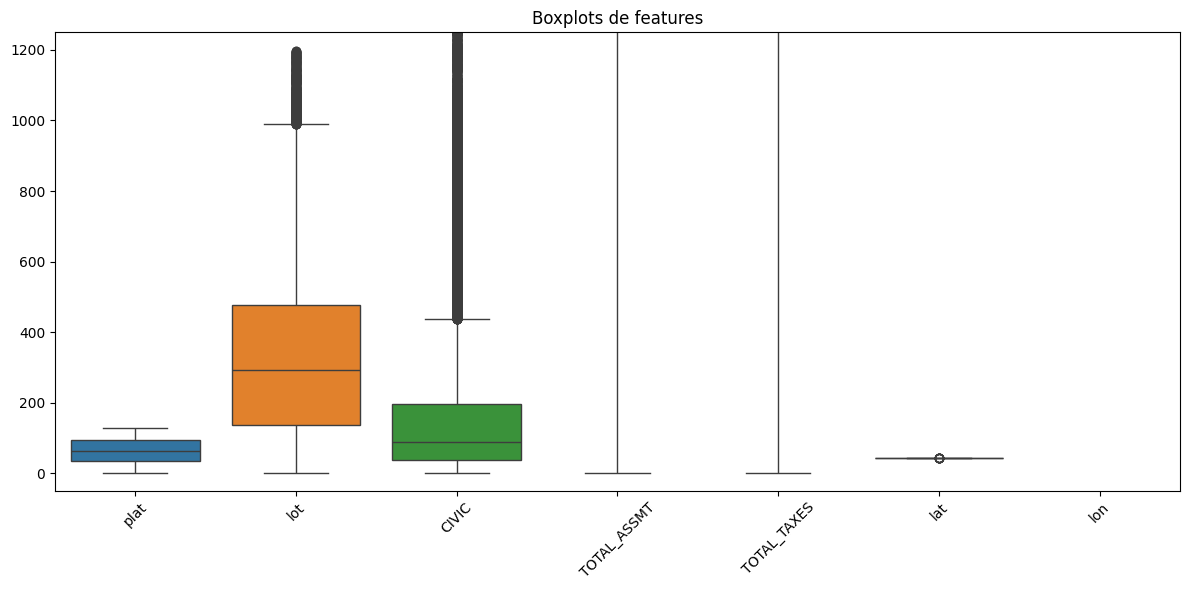

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_num.drop(columns=['CLASS','TOTAL_EXEMPT']))
plt.xticks(rotation=45)
plt.ylim(-50,1250)
plt.title("Boxplots de features")
plt.tight_layout()
plt.show()

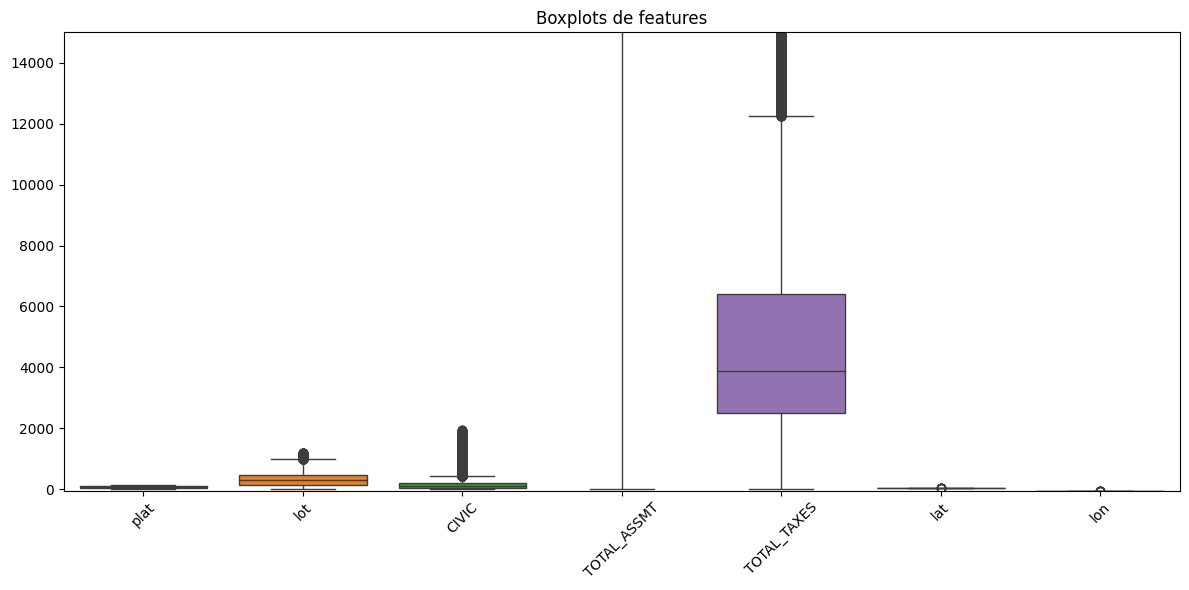

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_num.drop(columns=['CLASS','TOTAL_EXEMPT']))
plt.xticks(rotation=45)
plt.ylim(-50,15000)
plt.title("Boxplots de features")
plt.tight_layout()
plt.show()

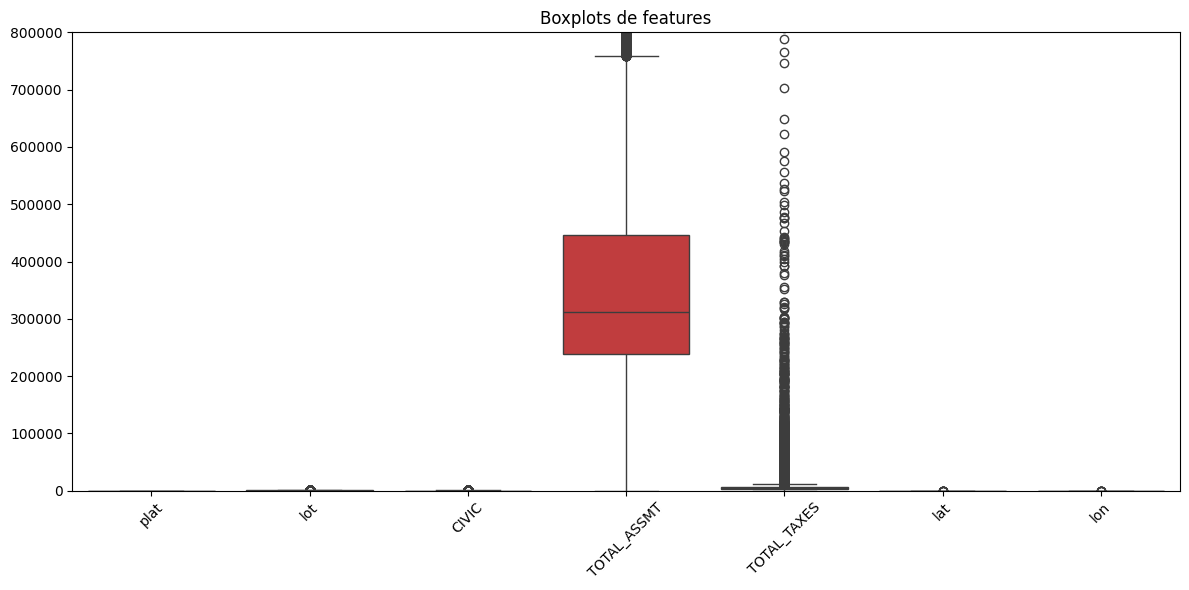

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_num.drop(columns=['CLASS','TOTAL_EXEMPT']))
plt.xticks(rotation=45)
plt.ylim(-50,800000)
plt.title("Boxplots de features")
plt.tight_layout()
plt.show()

## Columnas categóricas

In [ ]:
# Extracción de info y agregación de columnas nuevas
coords = df_cat["Property_Location"].str.extract(r"POINT\s*\(\s*([-\d\.]+)\s+([-\d\.]+)\s*\)")
df_cat.loc[:,"lon"] = pd.to_numeric(coords[0], errors="coerce")
df_cat.loc[:,"lat"] = pd.to_numeric(coords[1], errors="coerce")

factor = 10  

df_cat.loc[:,"lon_bin"] = (df_cat["lon"] * factor).round().astype("Int64")
df_cat.loc[:,"lat_bin"] = (df_cat["lat"] * factor).round().astype("Int64")

df_cat.loc[:,"geo_cell"] = df_cat["lat_bin"].astype(str) + "_" + df_cat["lon_bin"].astype(str)

# Se agrega variable de cluter
valid = df_cat[["lat", "lon"]].dropna()
kmeans = KMeans(n_clusters=10, random_state=42)
df_cat.loc[valid.index, "geo_cluster"] = kmeans.fit_predict(valid)

df_cat["geo_cluster"] = df_cat["geo_cluster"].astype("Int64").astype(str)

df_cat

/tmp/ipykernel_3478/1909210352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat.loc[:,"lon"] = pd.to_numeric(coords[0], errors="coerce")
/tmp/ipykernel_3478/1909210352.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat.loc[:,"lat"] = pd.to_numeric(coords[1], errors="coerce")
/tmp/ipykernel_3478/1909210352.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,P_ID,TAX_MAP,unit,SHORT_DESC,LEVY_CODE_1,SHORT_DESC 1,STREET,SUFFIX,FORMATED_ADDRESS,CITY,ZIP_POSTAL,FIRST_NAME,LAST_NAME,COMPANY,FREE_LINE_2,CIVIC 1,STREET 1,S_SUFFIX,UNIT,CITY 1,STATE,ZIP_POSTAL 1,Property_Location,CLASS,lon,lat,lon_bin,lat_bin,geo_cell,geo_cluster
0,12.0,000-0001-0022,0022,Utility,C01,C01,NaN,NaN,NaN,Providence,NaN,NaN,NaN,Algonquin Gas Transmission LLC,PO BOX 2629,NaN,NaN,NaN,NaN,Addison,TX,75001,POINT (-71.412747 41.824461),10.0,-71.412747,41.824461,-714,418,418_-714,8
1,807.0,005-0514-0000,0000,Single Family,OO01,OO01,Abbott,St,135 Abbott St,Providence,02906,LYNETTE,LOPES,NaN,135 ABBOTT ST,135,ABBOTT,ST,NaN,PROVIDENCE,RI,02906-1818,POINT (-71.402954036 41.842866001),1.0,-71.402954,41.842866,-714,418,418_-714,3
2,69878.0,077-0893-0000,0000,Single Family,OO01,OO01,Wilna,St,36 Wilna St,Providence,02904,K,Karpeh,NaN,36 Wilna St,36,Wilna,St,NaN,Providence,RI,02904,POINT (-71.415484981 41.858035988),1.0,-71.415485,41.858036,-714,419,419_-714,4
3,2050.0,008-0350-0000,0000,Single Family,OO01,OO01,Morris,Ave,120 Morris Ave,Providence,02906,NaN,NaN,NaN,120 Morris Ave,120,Morris,Ave,NaN,PROVIDENCE,RI,02906-3040,POINT (-71.398264026 41.83631701),1.0,-71.398264,41.836317,-714,418,418_-714,2
4,5030.0,016-0560-0000,0000,Single Family,OO01,OO01,John,St,22 John St,Providence,02906,Fergal,Casey,NaN,22 John St,22,John,St,NaN,Providence,RI,02906,POINT (-71.400355981 41.821832998),1.0,-71.400356,41.821833,-714,418,418_-714,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44029,65569.0,080-0866-0306,0306,Residential Condo,NO01,NO01,Devereux,NaN,31 Devereux Unit 306,Providence,02909,Marlene,Aad,NaN,410 Summer St,410,Summer,St,NaN,New Bedford,MA,02740,POINT (-71.471424965 41.834637989),23.0,-71.471425,41.834638,-715,418,418_-715,5
44030,69909.0,068-0843-0000,0000,CI Vacant Land,C01,C01,Chalkstone,Ave,306 Chalkstone Ave,Providence,02908,NaN,NaN,Solid Gold Properties Inc,PO Box 28317,NaN,PO Box 28317,NaN,NaN,Providence,RI,02908,POINT (-71.418151013 41.83625402),14.0,-71.418151,41.836254,-714,418,418_-714,8
44031,75378.0,007-0365-0004,0004,Residential Condo,OO01,OO01,Taft,Ave,44 Taft Ave,Providence,02906,Bilge,Celik,NaN,44 Taft Ave Unit 4,44,Taft,Ave,4,Providence,RI,02906,POINT (-71.395496992 41.842759006),23.0,-71.395497,41.842759,-714,418,418_-714,3
44032,48046.0,128-0137-0000,0000,Single Family,OO01,OO01,Rialto,St,22 Rialto St,Providence,02909,WAYNE,CIFELLI,NaN,22 RIALTO ST,22,RIALTO,ST,NaN,PROVIDENCE,RI,02908-3813,POINT (-71.452007029 41.837112998),1.0,-71.452007,41.837113,-715,418,418_-715,5


In [24]:
card = df_cat.nunique(dropna=True).sort_values(ascending=False)
card

P_ID                 44033
TAX_MAP              44033
FORMATED_ADDRESS     41748
Property_Location    39600
FREE_LINE_2          32834
lon                  32101
lat                  31466
LAST_NAME            16021
FIRST_NAME            8831
ZIP_POSTAL 1          5256
STREET 1              5228
COMPANY               3650
CIVIC 1               2078
STREET                1697
unit                  1466
UNIT                  1088
CITY 1                 900
ZIP_POSTAL              85
S_SUFFIX                48
STATE                   47
SHORT_DESC              27
CLASS                   27
SUFFIX                  16
geo_cluster             10
geo_cell                 9
LEVY_CODE_1              8
SHORT_DESC 1             8
CITY                     6
lat_bin                  4
lon_bin                  4
dtype: int64

In [25]:
cat_null_pct = (df_cat.isnull().mean()*100).sort_values(ascending=False)
cat_null_pct

UNIT                 89.648908
COMPANY              79.261480
FIRST_NAME           22.114730
LAST_NAME            21.969387
S_SUFFIX              8.000636
CIVIC 1               3.624472
SUFFIX                3.615388
ZIP_POSTAL            3.261116
STREET 1              2.402689
ZIP_POSTAL 1          0.086297
CITY                  0.079484
STATE                 0.031794
CITY 1                0.015897
FORMATED_ADDRESS      0.006813
STREET                0.006813
FREE_LINE_2           0.006813
unit                  0.002271
SHORT_DESC            0.002271
LEVY_CODE_1           0.002271
SHORT_DESC 1          0.002271
P_ID                  0.002271
TAX_MAP               0.002271
CLASS                 0.002271
Property_Location     0.000000
lon                   0.000000
lat                   0.000000
lon_bin               0.000000
lat_bin               0.000000
geo_cell              0.000000
geo_cluster           0.000000
dtype: float64

In [26]:
pd.DataFrame([cat_null_pct,card], index= ["porcentaje_nulos","cardinalidad"])

,UNIT,COMPANY,FIRST_NAME,LAST_NAME,S_SUFFIX,CIVIC 1,SUFFIX,ZIP_POSTAL,STREET 1,ZIP_POSTAL 1,CITY,STATE,CITY 1,FORMATED_ADDRESS,STREET,FREE_LINE_2,unit,SHORT_DESC,LEVY_CODE_1,SHORT_DESC 1,P_ID,TAX_MAP,CLASS,Property_Location,lon,lat,lon_bin,lat_bin,geo_cell,geo_cluster
porcentaje_nulos,89.648908,79.26148,22.11473,21.969387,8.000636,3.624472,3.615388,3.261116,2.402689,0.086297,0.079484,0.031794,0.015897,0.006813,0.006813,0.006813,0.002271,0.002271,0.002271,0.002271,0.002271,0.002271,0.002271,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cardinalidad,1088.000000,3650.00000,8831.00000,16021.000000,48.000000,2078.000000,16.000000,85.000000,5228.000000,5256.000000,6.000000,47.000000,900.000000,41748.000000,1697.000000,32834.000000,1466.000000,27.000000,8.000000,8.000000,44033.000000,44033.000000,27.000000,39600.0,32101.0,31466.0,4.0,4.0,9.0,10.0


## Cramer's V
- Elige qué tan asociadas están las features
- Se decide retirar del análisis las features P_ID, TAX_MAP, FORMATED_ADDRESS porque muestran gran cantidad de categorías, por lo que estos valores estarán descartados desde el principio
- De momento también se elimina FIRST_NAME, LAST_NAME, FORMATED_ADDRESS, Property_Location, FREE_LINE_2, pues ofrecen gran cantidad de categorías
- Se elije cv > 0.7 para afirmar que dos features son redunantes

In [27]:
cols_del = ["P_ID", "TAX_MAP", "FORMATED_ADDRESS", "FIRST_NAME","LAST_NAME", "Property_Location", "FREE_LINE_2", "lon","lat","lon_bin", "lat_bin" ]

cv = pd.DataFrame(index=df_cat.drop(columns=cols_del).columns, columns=df_cat.drop(columns=cols_del).columns, dtype=float)

for a in df_cat.drop(columns=cols_del).columns:
    for b in df_cat.drop(columns=cols_del).columns:
        print(a,b)
        valor = 1.0 if a == b else cramers_v(df_cat[a], df_cat[b])
        cv.loc[a, b] = np.float32(valor)

unit unit
unit SHORT_DESC
unit LEVY_CODE_1
unit SHORT_DESC 1
unit STREET
unit SUFFIX
unit CITY
unit ZIP_POSTAL
unit COMPANY
unit CIVIC 1
unit STREET 1
unit S_SUFFIX
unit UNIT
unit CITY 1
unit STATE
unit ZIP_POSTAL 1
unit CLASS
unit geo_cell
unit geo_cluster
SHORT_DESC unit
SHORT_DESC SHORT_DESC
SHORT_DESC LEVY_CODE_1
SHORT_DESC SHORT_DESC 1
SHORT_DESC STREET
SHORT_DESC SUFFIX
SHORT_DESC CITY
SHORT_DESC ZIP_POSTAL
SHORT_DESC COMPANY
SHORT_DESC CIVIC 1
SHORT_DESC STREET 1
SHORT_DESC S_SUFFIX
SHORT_DESC UNIT
SHORT_DESC CITY 1
SHORT_DESC STATE
SHORT_DESC ZIP_POSTAL 1
SHORT_DESC CLASS
SHORT_DESC geo_cell
SHORT_DESC geo_cluster
LEVY_CODE_1 unit
LEVY_CODE_1 SHORT_DESC
LEVY_CODE_1 LEVY_CODE_1
LEVY_CODE_1 SHORT_DESC 1
LEVY_CODE_1 STREET
LEVY_CODE_1 SUFFIX
LEVY_CODE_1 CITY
LEVY_CODE_1 ZIP_POSTAL
LEVY_CODE_1 COMPANY
LEVY_CODE_1 CIVIC 1
LEVY_CODE_1 STREET 1
LEVY_CODE_1 S_SUFFIX
LEVY_CODE_1 UNIT
LEVY_CODE_1 CITY 1
LEVY_CODE_1 STATE
LEVY_CODE_1 ZIP_POSTAL 1
LEVY_CODE_1 CLASS
LEVY_CODE_1 geo_cell
LEV

<Figure size 1000x800 with 0 Axes>

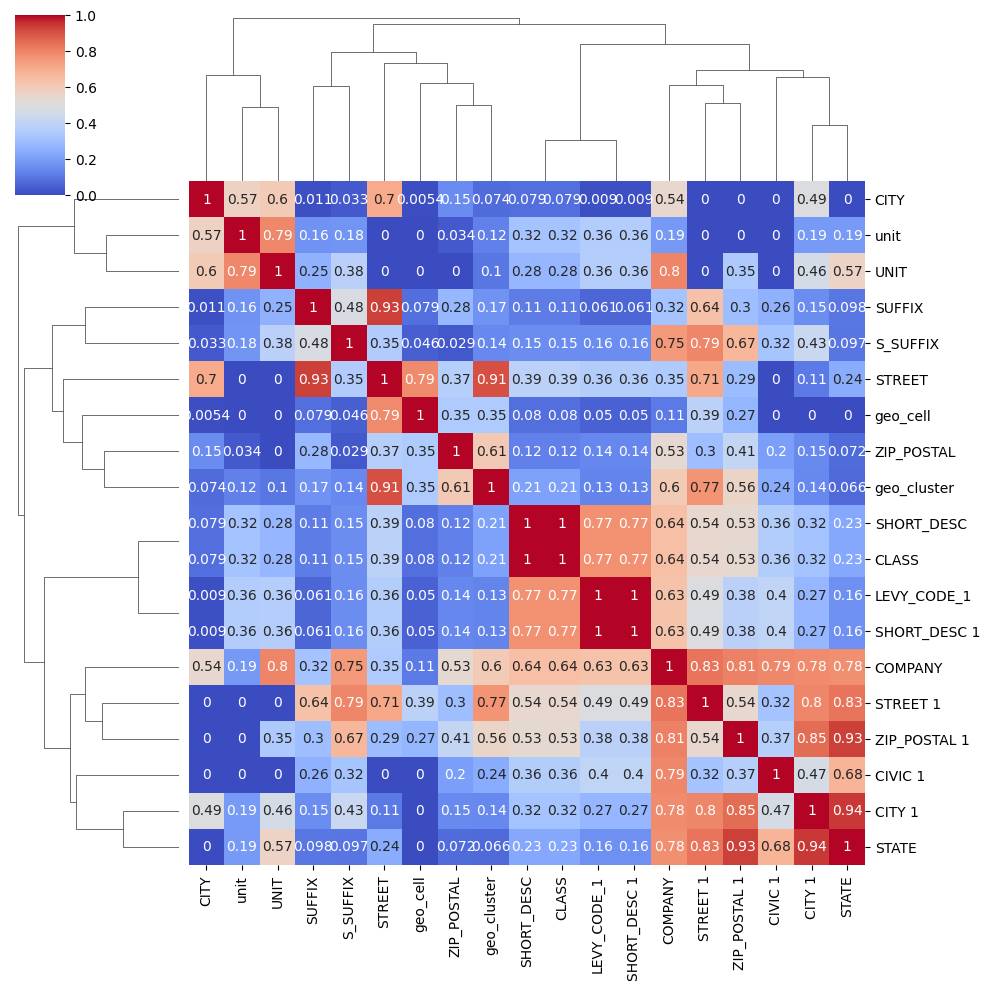

In [28]:
plt.figure(figsize=(10, 8))
sns.clustermap(cv,cmap='coolwarm', annot=True,figsize=(10, 10))
plt.show()



In [29]:
df_cat = df_cat[['P_ID', 'TAX_MAP', 'unit', 'SHORT_DESC 1', 'FORMATED_ADDRESS', 'CITY', 
                 'ZIP_POSTAL', 'COMPANY', 'CIVIC 1', 'STREET 1', 'S_SUFFIX', 'UNIT','CLASS', 'geo_cluster']]

In [30]:
cat_cols

['P_ID',
 'TAX_MAP',
 'unit',
 'SHORT_DESC',
 'LEVY_CODE_1',
 'SHORT_DESC 1',
 'STREET',
 'SUFFIX',
 'FORMATED_ADDRESS',
 'CITY',
 'ZIP_POSTAL',
 'FIRST_NAME',
 'LAST_NAME',
 'COMPANY',
 'FREE_LINE_2',
 'CIVIC 1',
 'STREET 1',
 'S_SUFFIX',
 'UNIT',
 'CITY 1',
 'STATE',
 'ZIP_POSTAL 1',
 'Property_Location',
 'CLASS']

## Análisis categórico y numérico

In [31]:
from scipy.stats import kruskal

df_eda = pd.concat([df_num, df_cat.drop(columns="CLASS")], axis=1)

# 1) Categóricas 
cat_cols = df_cat.columns.tolist()
df_eda["CLASS_CAT"] = df_eda["CLASS"].astype(str)
cat_cols_all = cat_cols + ["CLASS_CAT"]

# 2) Numéricas
num_cols_all = df_num.columns.tolist()

num_cols_all = [c for c in num_cols_all if c not in ["P_ID", "CLASS"]]


results = []
TOPK = 15  

for cat in cat_cols_all:
    
    cat_s = top_n_other(df_eda[cat], n=TOPK)
    
    if cat_s.nunique(dropna=True) < 2:
        continue

    for num in num_cols_all:
        v = df_eda[num]
        tmp = pd.DataFrame({"cat": cat_s, "num": v}).dropna()
        
        groups = [g["num"].values for _, g in tmp.groupby("cat") if len(g) > 0]
        if len(groups) < 2:
            continue

        # Kruskal
        stat, p = kruskal(*groups)

        # Tamaño de efecto (η)
        eta = correlation_ratio_eta(tmp["cat"], tmp["num"])

        results.append({
            "cat": cat,
            "num": num,
            "n": int(len(tmp)),
            "k_grupos": int(tmp["cat"].nunique()),
            "kruskal_p": float(p),
            "eta": eta
        })

res_36 = pd.DataFrame(results)

res_36 = res_36.sort_values(by=["eta", "kruskal_p"], ascending=[False, True])

res_36.head(40)


,cat,num,n,k_grupos,kruskal_p,eta
111,geo_cluster,lon,44034,10,0.000000e+00,0.949670
110,geo_cluster,lat,44034,10,0.000000e+00,0.940742
54,ZIP_POSTAL,lat,44034,16,0.000000e+00,0.875828
55,ZIP_POSTAL,lon,44034,16,0.000000e+00,0.872569
104,geo_cluster,plat,44033,10,0.000000e+00,0.771045
48,ZIP_POSTAL,plat,44033,16,0.000000e+00,0.650073
74,STREET 1,CIVIC,43938,16,0.000000e+00,0.425774
96,CLASS,plat,44033,16,0.000000e+00,0.378278
112,CLASS_CAT,plat,44033,16,0.000000e+00,0.378278
34,FORMATED_ADDRESS,CIVIC,43938,16,0.000000e+00,0.347922


,unit,UNIT
0,0022,MISSING
1,0000,MISSING
2,0000,MISSING
3,0000,MISSING
4,0000,MISSING
...,...,...
44029,0306,MISSING
44030,0000,MISSING
44031,0004,4
44032,0000,MISSING


## Qué categóricas correlacionadas aportan más al target?
- Del análisis de Cramer's V, se determinará cuál par de features aporta mejores resultados al target.
  * unit–UNIT
  * LEVY_CODE_1–SHORT_DESC 1

In [55]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

variables = [
    ["unit", "UNIT"], 
    ["LEVY_CODE_1","SHORT_DESC 1"], 
    ]

for var in variables:
    X_tmp = df_.dropna(subset="CLASS")[var].fillna("MISSING")
    y_tmp = df_.dropna(subset="CLASS")["CLASS"].astype(int)

    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_enc = enc.fit_transform(X_tmp)

    mi = mutual_info_classif(X_enc, y_tmp, discrete_features=True, random_state=42)
    print(dict(zip(var, mi)))

{'unit': np.float64(0.4121772910544784), 'UNIT': np.float64(0.2059436577196353)}
{'LEVY_CODE_1': np.float64(0.7482826245311879), 'SHORT_DESC 1': np.float64(0.7482826245311879)}


### Ablation study
- Se quiere determinar cuál bloque de variables aporta más al modelo

In [54]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

def make_pipeline(num_features, cat_features):
    pre = ColumnTransformer([
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_features),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features)
    ])
    model = RandomForestClassifier(random_state=42, n_estimators=300)
    return Pipeline([("pre", pre), ("model", model)])

base_num = ["TOTAL_ASSMT","TOTAL_EXEMPT","TOTAL_TAXES"]
y = df_.dropna(subset="CLASS")["CLASS"].astype(int)

experiments = {
    "base": (base_num, []),
    "base+CITY": (base_num, ["CITY"]),
    "base+ZIP": (base_num, ["ZIP_POSTAL"]),
    "base+latlon": (base_num + ["lat","lon"], []),
    "base+geocluster": (base_num, ["geo_cluster"]),
    "base+latlon+ZIP": (base_num + ["lat","lon"], ["ZIP_POSTAL"]),
    "base+latlon+ZIP+CITY": (base_num + ["lat","lon"], ["ZIP_POSTAL"], ["CITY"]),

}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = []
for name, (nums, cats) in experiments.items():
    
    pipe = make_pipeline(nums, cats)
    f1 = cross_val_score(pipe, df_.dropna(subset="CLASS")[nums + cats], y, cv=cv, scoring="f1_macro").mean()
    scores.append((name, f1))
    print(name, f1)

sorted(scores, key=lambda x: x[1], reverse=True)


/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


base 0.2957510730461203


/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


base+CITY 0.29754931378733024


/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Llenado de nulos
## for col in df_num.columns:
##     df_num.loc[:, col] = imputar_nulos_probabilisticamente(df_num[col])
## 
## null_pct = (df_num.isnull().mean()*100).sort_values(ascending=False)
## null_pct

# Conclusiones
- CLASS y SHORT_DESC están relacionados 1:1 (leakage) → no usar SHORT_DESC en entrenamiento.
- P_ID y TAX_MAP son únicos → no hay duplicados por identificador.
- Features numéricas presentan asimetría (distribuciones no normales).
- Se observa colinealidad entre TOTAL_ASSMT y TOTAL_TAXES (confirmado por matriz de correlación y VIF).
- TOTAL_EXEMPT está altamente concentrada (≈90% en un solo valor) → aporta señal limitada.
- LEVY_CODE_1 y SHORT_DESC 1 son redundantes → se conserva LEVY_CODE_1 y se descarta SHORT_DESC 1.
- Se descartan features de dirección/PII o alta cardinalidad para ML: STREET, SUFFIX, STREET 1, CIVIC, FORMATED_ADDRESS, unit, y campos de mailing (STATE, CITY 1, ZIP_POSTAL 1).
- geo_cell se descarta. Se conserva geo_cluster como señal geográfica agregada (y lat/lon si aplica).